# <span style="color:green">Project Sumary </span>

This is my Project Submission for my course <span style="color:green">**Advance Big Data Analytics BUAN 6347**</span>. 
For this project, I worked on a Machine Learning model using <span style="color:green">**MLlib of Pyspark on Google Cloud Platform**</span>.


</p> This jupyter notebook is preceeded by creating a cluster on GCP with one master node and 2 worker nodes as VM instances. 
    * Installation of Jupyter notebook and other required packages was done on SSH of my Master node.
        * To use the jupyter notebook on web browser, external IP address of Master node along with the tcp port of its vm instance was taken
    * Setting the 3 essential components of the project:
        * VM instances clusters
        * Firewall
        * External IP address
    
</p> Once the environment is set up, I follow the steps to data analysis for the model:
    - Import packages
    - Instantiate the Spark Session
    - Read file and statistical exploration
    - Imputation and Sampling
    - ML Pipeline
    - Train, test, dev split
    - Modelling
    - Evaluation

# <span style="color:green">**I. Import Packages**</span>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import re

In [5]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing


# <span style="color:green">**II. Spark Session**</span>

In [6]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
#sc = SparkContext('local')
#spark = SparkSession(sc)

In [7]:
spark = SparkSession.builder.appName("Predict Stroke Data").getOrCreate()


In [8]:
input_dir = 'gs://data_stroke_1/'
df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(input_dir+'train_2v.csv')

# <span style="color:green"> **III. Statistical Data Exploration** </span>

In [6]:
featureColumns = ['age', 'avg_glucose_level', 'hypertension']

In [7]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



([<matplotlib.axis.XTick at 0x7fde6600d3d0>,
 <a list of 2 Text xticklabel objects>)

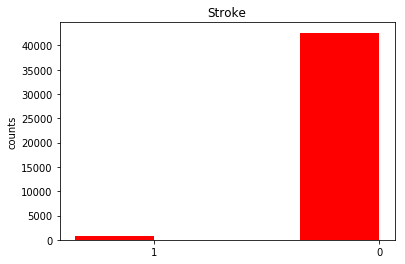

In [8]:
responses = df.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

**from here we see that this is highly imbalanced dataset***

In [9]:
#print("there are in total {} work type categories ".format(len(df1.work_type.unique())))
#print("there are in total {} Residence type categories ".format(len(df1.Residence_type.unique())))
#print("there are in total {} smoking status".format(len(df1.smoking_status.unique())))

</p>For few perations spark doesn't support, so we convert them to pandas

In [9]:
imputeDF = df
imputeDF_Pandas = imputeDF.toPandas()

In [10]:
imputeDF_Pandas.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,None,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,None,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,None,0


# first binary map, then impute, then one hot encode

In [10]:
#smoke_onehot = pd.get_dummies(imputeDF_Pandas['smoking_status'],columns='smoking_status',prefix='smoke')
#imputeDF_Pandas =pd.concat([imputeDF_Pandas, smoke_onehot], axis=1)

In [6]:
imputeDF_Pandas['gender'] = imputeDF_Pandas['gender'].map({'Male':1, 'Female': 0})
imputeDF_Pandas['ever_married'] = imputeDF_Pandas['ever_married'].map({'Yes':1, 'No': 0})
imputeDF_Pandas['Residence_type'] = imputeDF_Pandas['Residence_type'].map({'Urban':1, 'Rural': 0})

In [184]:
imputeDF_Pandas.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1.0,3.0,0,0,0,children,0,95.12,18.0,None,0
1,30468,1.0,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0
2,16523,0.0,8.0,0,0,0,Private,1,110.89,17.6,None,0
3,56543,0.0,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0
4,46136,1.0,14.0,0,0,0,Never_worked,0,161.28,19.1,None,0


In [34]:
imputeDF_Pandas.shape

(43400, 12)

In [35]:
countofnulls = imputeDF_Pandas.isnull().sum().sum()
print("count of nulls is",countofnulls)
#Percentage of nulls 
totalelements = imputeDF_Pandas.count().sum()
percentageofnulls=(countofnulls*100/totalelements)
print("percentage of nulls is",percentageofnulls)

('count of nulls is', 36409)
('percentage of nulls is', 7)


In [185]:
imputeDF_Pandas.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1.0,3.0,0,0,0,children,0,95.12,18.0,None,0
1,30468,1.0,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0
2,16523,0.0,8.0,0,0,0,Private,1,110.89,17.6,None,0
3,56543,0.0,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0
4,46136,1.0,14.0,0,0,0,Never_worked,0,161.28,19.1,None,0


In [8]:

#df_ng = imputeDF_Pandas[['gender']].isnull().sum()
print(imputeDF_Pandas[['gender']].isnull().sum())
print(imputeDF_Pandas.gender.unique())
print(imputeDF_Pandas[['hypertension']].isnull().sum())
print(imputeDF_Pandas.hypertension.unique())
print(imputeDF_Pandas[['heart_disease']].isnull().sum())
print(imputeDF_Pandas.heart_disease.unique())
print(imputeDF_Pandas[['ever_married']].isnull().sum())
print(imputeDF_Pandas.ever_married.unique())
print(imputeDF_Pandas[['work_type']].isnull().sum())
print(imputeDF_Pandas.work_type.unique())
print(imputeDF_Pandas[['Residence_type']].isnull().sum())
print(imputeDF_Pandas.Residence_type.unique())
print(imputeDF_Pandas[['avg_glucose_level']].isnull().sum())
#print(imputeDF_Pandas['avg_glucose_level'].unique())
print(imputeDF_Pandas[['bmi']].isnull().sum())
#print(imputeDF_Pandas['bmi'].unique())
print(imputeDF_Pandas[['smoking_status']].isnull().sum())
print(imputeDF_Pandas.smoking_status.unique())

gender    11
dtype: int64
[ 1.  0. nan]
hypertension    0
dtype: int64
[0 1]
heart_disease    0
dtype: int64
[0 1]
ever_married    0
dtype: int64
[0 1]
work_type    0
dtype: int64
[u'children' u'Private' u'Never_worked' u'Self-employed' u'Govt_job']
Residence_type    0
dtype: int64
[0 1]
avg_glucose_level    0
dtype: int64
bmi    1462
dtype: int64
smoking_status    13292
dtype: int64
[None u'never smoked' u'formerly smoked' u'smokes']


As we see, there are missing values in three columns:
    * BMI
    * Smoking Status
    * Gender
    Two being categorical Value
    
Categorical imputations can be categorised as Binary class and Multiclass:
   
   </p>  (a) <span style="color:green">**KNN**</span> for Binary Class (Gender). 
   
   </p>  (b) <span style="color:green">**Logistic/SVM/Softmax**</span> for Multiclass (Smoking Status).

<span style="color:green"> **KNN Impute for binary class** </span>

In [7]:
a = imputeDF_Pandas[['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'stroke', 'gender']]

a.isnull().sum()

age                   0
hypertension          0
heart_disease         0
ever_married          0
avg_glucose_level     0
stroke                0
gender               11
dtype: int64

In [8]:
a1 = a.dropna()

In [9]:
A = a1.drop(['gender'], axis=1)

In [10]:
A.isnull().sum()

age                  0
hypertension         0
heart_disease        0
ever_married         0
avg_glucose_level    0
stroke               0
dtype: int64

In [11]:
gen = imputeDF_Pandas[['gender']]
len(gen)
gen = pd.DataFrame(gen)

In [12]:
gen.isnull().sum()
#gen.head()

gender    11
dtype: int64

In [13]:
gen_nonull = gen.dropna()

In [14]:
gen_nonull.isnull().sum()

len(gen_nonull)

43389

In [15]:
b = pd.DataFrame(gen_nonull)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(A, b)

/opt/conda/anaconda/bin/ipython:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [17]:
gen_pred = a.loc[imputeDF_Pandas['gender'].isnull()]

In [20]:
gen_pred.drop(['gender'], axis=1, inplace=True)

## inplace will save the change in the orginal gen_pred dataframe

/opt/conda/anaconda/bin/ipython:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  #!/opt/conda/anaconda/bin/python


In [21]:
### this was made when we wanted to predict only for the missing gender columns; while now we do knn predictions for the entire gen column for easy impute
gen_pred

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke
2914,26.0,0,0,0,143.33,0
10768,46.0,0,0,0,83.28,0
15620,27.0,0,0,0,62.45,0
15838,53.0,0,0,1,89.65,0
19748,39.0,0,0,1,95.59,0
21041,19.0,0,0,0,75.76,0
21192,49.0,0,0,1,94.88,0
24252,51.0,0,0,1,91.75,0
26199,10.0,0,0,0,72.05,0
26831,53.0,0,0,1,65.29,0


In [128]:
imputed_gen = knn.predict(gen_pred)

In [18]:
## for imputation for the entire column

a_wo_gen = a.drop(['gender'], axis=1)

In [19]:
a_wo_gen.head()
a_wo_gen.shape

(43400, 6)

In [20]:
imp_g = knn.predict(a_wo_gen)

In [21]:
len(imp_g)

43400

In [22]:
#the predicted row

imp_g_df = pd.DataFrame(imp_g, columns = ['gender'])

In [23]:
imp_g_df.isnull().sum()


gender    0
dtype: int64

In [28]:
## the predicted values for the imputation
imputed_gen

NameError: name 'imputed_gen' is not defined

In [126]:
##fillna only certain columns
#df[['a','b']].fillna(value=0)

#i_g = {'gender': imputed_gen}
#imputeDF_Pandas['gender'].fillna(value=imputed_gen_df)  CAN'T!!!

#try GROUPBY AND REPLACE
##fillna can take a Series, and a list can be converted to a Series. Wrapping your list in pd.Series() worked for me:
###result = ser.fillna(pd.Series([np.nan]))

##final_i_g = imputeDF_Pandas[['gender']].fillna(pd.Series(i_g_dict)) --- nothing 
##data.iloc[[0,3,6,24], [0,5,6]] # 1st, 4th, 7th, 25th row + 1st 6th 7th columns.

##data.iloc[0:5, 5:8] # first 5 rows and 5th, 6th, 7th columns of data frame

#imputeDF_Pandas.iloc[[1],[1]]
####df['C'] = df['A'] + df['B']
#i_g_3 = imputeDF_Pandas[['gender']]
#i_g_4 = i_g_3.combine_first(imputed_gen_df)

In [24]:
i_g = imputeDF_Pandas[['gender']].fillna(value=5)

In [25]:
i_g.isnull().sum()

gender    0
dtype: int64

In [26]:
i_g = pd.DataFrame(i_g)

In [27]:
i_g.gender.unique()

array([1., 0., 5.])

# LOOP CODE 

In [24]:
###chek
#(imputeDF_Pandas.iloc[[2914],[1]].isnull()).bool()
#for i in range(0, 43399):
    #j = 0
   # if (imputeDF_Pandas.iloc[[i],[1]].isnull()).bool():
      #  imputeDF_Pandas.iloc[[i],[0]] = imputed_gen[j]
      #  j = j+1
      #imputeDF_Pandas.isnull().sum()          

In [139]:
j = 0
for i in range(0, 43399):
    
    if (i_g.iloc[[i],[0]] == 5).bool():
        i_g.iloc[[i],[0]] = imputed_gen[j]
        j = j+1 

In [134]:
for i in range(0, 43399):
    
    if (i_g.iloc[[i],[0]] == 5).bool():
        for j in range(0,10):
            i_g.iloc[[i],[0]] = imputed_gen[j]
            break
 

In [28]:
### CURRENTLY USED
## pick change only the required fields in the df 
##i_g is the original gender column; imp_g is the knn predicted one

for i in range(0, 43399):
    
    if (i_g.iloc[[i],[0]] == 5).bool():
        i_g.iloc[[i],[0]] = imp_g[i]
         

In [29]:
i_g.gender.unique()

array([1., 0.])

In [30]:
imputeDF_Pandas['gender_imputed'] = i_g['gender']

In [31]:
imputeDF_Pandas.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_imputed
0,30669,1.0,3.0,0,0,0,children,0,95.12,18.0,None,0,1.0
1,30468,1.0,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0,1.0
2,16523,0.0,8.0,0,0,0,Private,1,110.89,17.6,None,0,0.0
3,56543,0.0,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0,0.0
4,46136,1.0,14.0,0,0,0,Never_worked,0,161.28,19.1,None,0,1.0


In [32]:
imputeDF_Pandas.loc[imputeDF_Pandas['gender'].isnull()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_imputed
2914,56156,NaN,26.0,0,0,0,Private,0,143.33,22.4,formerly smoked,0,0.0
10768,26188,NaN,46.0,0,0,0,Private,0,83.28,NaN,never smoked,0,0.0
15620,52984,NaN,27.0,0,0,0,Private,1,62.45,NaN,smokes,0,0.0
15838,24893,NaN,53.0,0,0,1,Private,0,89.65,NaN,None,0,1.0
19748,13471,NaN,39.0,0,0,1,Govt_job,1,95.59,32.0,formerly smoked,0,1.0
21041,31015,NaN,19.0,0,0,0,Private,0,75.76,32.2,formerly smoked,0,1.0
21192,27043,NaN,49.0,0,0,1,Private,1,94.88,37.2,never smoked,0,1.0
24252,51111,NaN,51.0,0,0,1,Private,0,91.75,32.2,formerly smoked,0,0.0
26199,42452,NaN,10.0,0,0,0,children,0,72.05,21.2,formerly smoked,0,1.0
26831,49812,NaN,53.0,0,0,1,Govt_job,1,65.29,NaN,None,0,0.0


In [34]:
compare_gender = imputeDF_Pandas[imputeDF_Pandas.gender == imputeDF_Pandas.gender_imputed]

In [35]:
compare_gender.shape

(43389, 13)

In [33]:
final_imp_g_df = imputeDF_Pandas.drop(['gender'], axis = 1)

In [34]:
final_imp_g_df.head()
#print(final_imp_g_df.shape)

,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_imputed
0,30669,3.0,0,0,0,children,0,95.12,18.0,None,0,1.0
1,30468,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0,1.0
2,16523,8.0,0,0,0,Private,1,110.89,17.6,None,0,0.0
3,56543,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0,0.0
4,46136,14.0,0,0,0,Never_worked,0,161.28,19.1,None,0,1.0


**<span style="color:green">Imputing Multiclass Labels</span>**

**Smoking Status**

In [35]:
ss = pd.DataFrame(final_imp_g_df.drop(['bmi', 'work_type'],axis=1))

In [36]:
ss.isnull().sum()

id                       0
age                      0
hypertension             0
heart_disease            0
ever_married             0
Residence_type           0
avg_glucose_level        0
smoking_status       13292
stroke                   0
gender_imputed           0
dtype: int64

In [37]:
ss.shape

(43400, 10)

In [38]:
x_ss = ss.dropna()

In [39]:
x_ss.shape

(30108, 10)

In [40]:
X_ss = x_ss.drop(['smoking_status'], axis=1)

In [41]:
y_ss = pd.DataFrame(x_ss['smoking_status'], columns=['smoking_status'])

In [42]:
print(X_ss.shape)
print(y_ss.shape)
print(y_ss.smoking_status.unique())
print(y_ss.dtypes)

(30108, 9)
(30108, 1)
[u'never smoked' u'formerly smoked' u'smokes']
smoking_status    object
dtype: object


In [44]:
##not used
ss_pred = pd.DataFrame(ss['smoking_status'], columns=['smoking_status'])

In [43]:
# encoding train labels 
encoder = preprocessing.LabelEncoder()
encoder.fit(y_ss)
Y = encoder.transform(y_ss)

/home/mitali11bharali/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mitali11bharali/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
Y

array([1, 0, 0, ..., 0, 1, 1])

In [45]:
Y_ss =pd.DataFrame(Y, columns=['smoking_status'])
Y_ss.smoking_status.unique()

array([1, 0, 2])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_ss_scaled = scaler.fit_transform(X_ss)

/home/mitali11bharali/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/mitali11bharali/.local/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_ss_scaled, Y)

In [48]:
pred_ss = pd.DataFrame(ss.drop(['smoking_status'], axis=1))

In [49]:
pred_ss.shape

(43400, 9)

In [50]:
pred_scaled = scaler.transform(pred_ss)

/opt/conda/anaconda/bin/ipython:1: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  #!/opt/conda/anaconda/bin/python


In [51]:
##Y_pred = final_model.predict(X_test_scaled)
##Y_pred_label = list(encoder.inverse_transform(Y_pred))

Y_pred = clf.predict(pred_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

In [52]:
Y_pred_df = pd.DataFrame(Y_pred, columns= ['smoking_status'])
print(Y_pred_df.shape)
print(Y_pred_df.smoking_status.unique())

Y_pred_label_df = pd.DataFrame(Y_pred_label, columns= ['smoking_status'])
print(Y_pred_label_df.shape)
print(Y_pred_label_df.smoking_status.unique())

(43400, 1)
[1 0 2]
(43400, 1)
[u'never smoked' u'formerly smoked' u'smokes']


In [53]:
i_ss = pd.DataFrame(ss[['smoking_status']].fillna(value=5))

In [54]:
print(i_ss.isnull().sum())
print(i_ss.smoking_status.unique())

smoking_status    0
dtype: int64
[5 u'never smoked' u'formerly smoked' u'smokes']


In [55]:
for i in range(0, 43399):
    
    if (i_ss.iloc[[i],[0]] == 5).bool():
        i_ss.iloc[[i],[0]] = Y_pred_label[i]

In [56]:
print(i_ss.smoking_status.unique())
print(i_ss.shape)

[u'never smoked' u'formerly smoked' u'smokes']
(43400, 1)


In [57]:
final_imp_g_df['smoking_status_imputed'] = i_ss['smoking_status']

In [58]:
final_imp_gss = final_imp_g_df.drop(['smoking_status'], axis=1)

In [59]:
print(final_imp_gss.isnull().sum())
print(final_imp_gss.shape)
final_imp_gss.head()

id                           0
age                          0
hypertension                 0
heart_disease                0
ever_married                 0
work_type                    0
Residence_type               0
avg_glucose_level            0
bmi                       1462
stroke                       0
gender_imputed               0
smoking_status_imputed       0
dtype: int64
(43400, 12)


,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,gender_imputed,smoking_status_imputed
0,30669,3.0,0,0,0,children,0,95.12,18.0,0,1.0,never smoked
1,30468,58.0,1,0,1,Private,1,87.96,39.2,0,1.0,never smoked
2,16523,8.0,0,0,0,Private,1,110.89,17.6,0,0.0,never smoked
3,56543,70.0,0,0,1,Private,0,69.04,35.9,0,0.0,formerly smoked
4,46136,14.0,0,0,0,Never_worked,0,161.28,19.1,0,1.0,never smoked


**<span style="color:green">Continuous Variable Imputation</span>**

** BMI **

In [60]:
final_imp = final_imp_gss.fillna(final_imp_gss['bmi'].mean())

In [61]:
final_imp.isnull().sum()
final_imp.shape
final_imp.head()

,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,gender_imputed,smoking_status_imputed
0,30669,3.0,0,0,0,children,0,95.12,18.0,0,1.0,never smoked
1,30468,58.0,1,0,1,Private,1,87.96,39.2,0,1.0,never smoked
2,16523,8.0,0,0,0,Private,1,110.89,17.6,0,0.0,never smoked
3,56543,70.0,0,0,1,Private,0,69.04,35.9,0,0.0,formerly smoked
4,46136,14.0,0,0,0,Never_worked,0,161.28,19.1,0,1.0,never smoked


In [62]:
from sklearn.impute import SimpleImputer

#imp_bmi = SimpleImputer(missing_values=np.nan, strategy='median')
#imp_bmi.fit(final_imp_gss['bmi'])
#df["price"]=imp.transform(df["price"])


##imputed_DF = DF
#for col in final_imp_gss.columns:
 ##   imputed_column = imp_bmi.fit_transform(final_imp_gss[col]).T
    #Fill in Series on DataFrame
   ## imputed_DF[col] = imputed_column

df_2_9 = final_imp_gss[(final_imp_gss['age'] >=2 ) & (imputeDF_Pandas['age'] <= 9)]
values = {'BMI':17.125}
df_2_9 = df_2_9.fillna(value = values)
df_10_13 = final_imp_gss[(final_imp_gss['age'] >=10 ) & (imputeDF_Pandas['age'] <= 13)]
values = {'BMI':19.5}
df_10_13 = df_10_13.fillna(value = values)
df_14_17 = final_imp_gss[(final_imp_gss['age'] >=14 ) & (imputeDF_Pandas['age'] <= 17)]
values = {'BMI':23.05}
df_14_17 = df_14_17.fillna(value = values)
df_18_24 = final_imp_gss[(final_imp_gss['age'] >=18 ) & (imputeDF_Pandas['age'] <= 24)]
values = {'BMI':27.1}
df_18_24 = df_18_24.fillna(value = values)
df_25_29 = final_imp_gss[(final_imp_gss['age'] >=25 ) & (imputeDF_Pandas['age'] <= 29)]
values = {'BMI':27.9}
df_25_29 = df_25_29.fillna(value = values)
df_30_34 = final_imp_gss[(final_imp_gss['age'] >=30 ) & (imputeDF_Pandas['age'] <= 34)]
values = {'BMI':29.6}
df_30_34 = df_30_34.fillna(value = values)
df_35_44 = final_imp_gss[(final_imp_gss['age'] >=35 ) & (imputeDF_Pandas['age'] <= 44)]
values = {'BMI':30.15}
df_35_44 = df_35_44.fillna(value = values)
df_45_49 = final_imp_gss[(final_imp_gss['age'] >=45 ) & (imputeDF_Pandas['age'] <= 49)]
values = {'BMI':29.7}
df_45_49 = df_45_49.fillna(value = values)
df_50_59 = final_imp_gss[(final_imp_gss['age'] >=50 ) & (imputeDF_Pandas['age'] <= 59)]
values = {'BMI':29.95}
df_50_59 = df_50_59.fillna(value = values)
df_60_74 = final_imp_gss[(final_imp_gss['age'] >=60 ) & (imputeDF_Pandas['age'] <= 74)]
values = {'BMI':30.1}
df_60_74 = df_60_74.fillna(value = values)
df_75_plus = final_imp_gss[(final_imp_gss['age'] >75 )]
values = {'BMI':28.1}
df_75_plus = df_75_plus.fillna(value = values)

all_frames = [df_2_9, df_10_13, df_14_17, df_18_24, df_25_29, df_30_34, df_35_44, df_45_49, df_50_59, df_60_74, df_75_plus]
df_combined = pd.concat(all_frames)
df_combined_converted = spark.createDataFrame(df_combined)
imputeDF = df_combined_converted


imputeDF = imputeDF.toPandas()

In [63]:
smoke_onehot = pd.get_dummies(final_imp['smoking_status_imputed'],columns='smoking_status_imputed',prefix='smoke')
final_en1 =pd.concat([final_imp, smoke_onehot], axis=1)

In [64]:
work_ty_onehot = pd.get_dummies(final_en1['work_type'],columns='work_type',prefix='work')
final_en2 =pd.concat([final_en1, work_ty_onehot], axis=1)

In [65]:
final_pp = final_en2.drop(['work_type', 'smoking_status_imputed'], axis=1)

In [66]:
final_pp.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_imputed,smoke_formerly smoked,smoke_never smoked,smoke_smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children
0,30669,3.0,0,0,0,0,95.12,18.0,0,1.0,0,1,0,0,0,0,0,1
1,30468,58.0,1,0,1,1,87.96,39.2,0,1.0,0,1,0,0,0,1,0,0
2,16523,8.0,0,0,0,1,110.89,17.6,0,0.0,0,1,0,0,0,1,0,0
3,56543,70.0,0,0,1,0,69.04,35.9,0,0.0,1,0,0,0,0,1,0,0
4,46136,14.0,0,0,0,0,161.28,19.1,0,1.0,0,1,0,0,1,0,0,0


SCALING

In [67]:
Y_tr = final_pp['stroke']

In [68]:
X_tr = final_pp.drop(['stroke'], axis=1)

In [91]:
X_tr.head()
#X_tr.columns

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_imputed,smoke_formerly smoked,smoke_never smoked,smoke_smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children
0,30669,3.0,0,0,0,0,95.12,18.0,1.0,0,1,0,0,0,0,0,1
1,30468,58.0,1,0,1,1,87.96,39.2,1.0,0,1,0,0,0,1,0,0
2,16523,8.0,0,0,0,1,110.89,17.6,0.0,0,1,0,0,0,1,0,0
3,56543,70.0,0,0,1,0,69.04,35.9,0.0,1,0,0,0,0,1,0,0
4,46136,14.0,0,0,0,0,161.28,19.1,1.0,0,1,0,0,1,0,0,0


In [111]:
#X = imputeDF.toPandas().filter(items=['age', 'avg_glucose_level','hypertension','heart disease','BMI'])
#Y = imputeDF.toPandas().filter(items=['stroke'])
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train_org, X_test_org , y_train, y_test = train_test_split(X_tr, Y_tr, random_state = 0)

scaler = MinMaxScaler()
scaler.fit(X_train_org)
X_train = scaler.transform(X_train_org)
X_test = scaler.transform(X_test_org)

/home/mitali11bharali/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##age glucose and hypertension passed through

In [63]:
#### NOT USED AS YET

print('class labels:', np.unique(Y))

('class labels:', array([0, 1, 2]))


# <span style="color:green"> **Sampling** </span>

Sampling is an essential part of any data analysis and ML algorithm. 
Most of the real world datasets would not be cleaned and most importantly will not be *balanced* (or say normally distributed)
</p>
The dataset we are using here is higly <span style="color:green"> ***unbalanced***</span>, hence special attention and treatment is required to bring out the true representation of the data in our training set so as we avoid bais in our model.
</p>
The three types of Sampling treatment we use are:
    * Adjust Class weights of the cost function 
    * Balanced Bagging
    * Smote Oversampling
    
 While Class weight adjust is the best way and the most accurate, I have used Smote as it is easy to use.
 


**SMOTE**

In [70]:
sm = SMOTE(random_state=12, ratio = 'auto', kind = 'regular')

In [71]:
sampled_df = sm.fit_sample(X_tr, Y_tr)

In [84]:
x_train_res, y_train_res = sm.fit_sample(X_tr, Y_tr)
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Resampled dataset shape Counter({0: 42617, 1: 42617})


X_train contains all the columns of the data except the Stroke column.
Y_train contains the Stroke column data.
</p>Combine the resampled data into one *spark dataframe*

In [77]:
x_train_res

array([[3.06690000e+04, 3.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.04680000e+04, 5.80000000e+01, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.65230000e+04, 8.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.88974364e+04, 7.89929391e+01, 0.00000000e+00, ...,
        7.13277015e-01, 2.86722985e-01, 0.00000000e+00],
       [6.50314154e+04, 8.04889959e+01, 0.00000000e+00, ...,
        4.88995865e-01, 0.00000000e+00, 0.00000000e+00],
       [6.63958571e+04, 7.83068789e+01, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [97]:
dataframe_1 = pd.DataFrame(x_train_res, columns = ['id', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'gender_imputed', 'smoke_formerly smoked', 'smoke_never smoked', 'smoke_smokes', 'work_Govt_job', 'work_Never_worked', 'work_Private', 'work_Self-employed', 'work_children' ])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['stroke'])
# frames = [dataframe_1, dataframe_2]
#result = dataframe_1.append(dataframe_2)
result = dataframe_1.combine_first(dataframe_2)

In [100]:
result.head()
##result.isnull().sum()

,Residence_type,age,avg_glucose_level,bmi,ever_married,gender_imputed,heart_disease,hypertension,id,smoke_formerly smoked,smoke_never smoked,smoke_smokes,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children
0,0.0,3.0,95.12,18.0,0.0,1.0,0.0,0.0,30669.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,58.0,87.96,39.2,1.0,1.0,0.0,1.0,30468.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,8.0,110.89,17.6,0.0,0.0,0.0,0.0,16523.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,70.0,69.04,35.9,1.0,0.0,0.0,0.0,56543.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,14.0,161.28,19.1,0.0,1.0,0.0,0.0,46136.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [94]:
#### same

dataframe_1 = pd.DataFrame(x_train_res)
dataframe_2 = pd.DataFrame(y_train_res, columns = ['stroke'])
# frames = [dataframe_1, dataframe_2]
result = dataframe_1.append(dataframe_2)

In [101]:
imputeDF_f = spark.createDataFrame(result)

**<span style="color:green">Distribution After SMOTE OVERSAMPLING</span>**

([<matplotlib.axis.XTick at 0x7f0e1a8e1b90>,
 <a list of 2 Text xticklabel objects>)

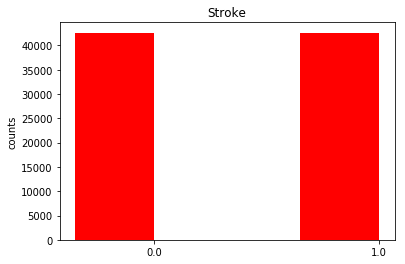

In [102]:
#after smote

responses = imputeDF_f.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

# <span style="color:green">Building Spark ML Pipeline </span>

In [105]:
featureColumns = ['id', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'gender_imputed', 'smoke_formerly smoked', 'smoke_never smoked', 'smoke_smokes', 'work_Govt_job', 'work_Never_worked', 'work_Private', 'work_Self-employed', 'work_children']

In [104]:
binarizer = Binarizer(threshold=0.0, inputCol="stroke", outputCol="label")
binarizedDF = binarizer.transform(imputeDF_f)
binarizedDF = binarizedDF.drop('stroke')

In [106]:
assembler = VectorAssembler(inputCols = featureColumns, outputCol = "features")
assembled = assembler.transform(binarizedDF)
print(assembled)

DataFrame[Residence_type: double, age: double, avg_glucose_level: double, bmi: double, ever_married: double, gender_imputed: double, heart_disease: double, hypertension: double, id: double, smoke_formerly smoked: double, smoke_never smoked: double, smoke_smokes: double, work_Govt_job: double, work_Never_worked: double, work_Private: double, work_Self-employed: double, work_children: double, label: double, features: vector]


**Splitting Data**

In [107]:
(trainingData, testData) = assembled.randomSplit([0.7, 0.3], seed=0)
print("Distribution of Ones and Zeros in trainingData is: ", trainingData.groupBy("label").count().take(3))

('Distribution of Ones and Zeros in trainingData is: ', [Row(label=0.0, count=29902), Row(label=1.0, count=29887)])


In [108]:
trainingData.count(), testData.count()

(59789, 25445)

In [109]:
pd.DataFrame(trainingData.take(5), columns=trainingData.columns)

,Residence_type,age,avg_glucose_level,bmi,ever_married,gender_imputed,heart_disease,hypertension,id,smoke_formerly smoked,smoke_never smoked,smoke_smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,label,features
0,0.0,0.08,76.04,12.8,0.0,1.0,0.0,0.0,68046.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(68046.0, 0.08, 0.0, 0.0, 0.0, 0.0, 76.04, 12...."
1,0.0,0.08,84.93,30.6,0.0,1.0,0.0,0.0,26091.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(26091.0, 0.08, 0.0, 0.0, 0.0, 0.0, 84.93, 30...."
2,0.0,0.08,135.52,12.8,0.0,0.0,0.0,0.0,43475.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(43475.0, 0.08, 0.0, 0.0, 0.0, 0.0, 135.52, 12..."
3,0.0,0.16,69.79,13.0,0.0,1.0,0.0,0.0,41500.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(41500.0, 0.16, 0.0, 0.0, 0.0, 0.0, 69.79, 13...."
4,0.0,0.16,78.41,17.0,0.0,1.0,0.0,0.0,69327.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(69327.0, 0.16, 0.0, 0.0, 0.0, 0.0, 78.41, 17...."


***Training***

In [110]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

***Testing***

In [111]:
predictions = model.transform(testData)

# AUC-ROC

In [112]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Aread under ROC score is : ", metrics.areaUnderROC)

('Test Data Aread under ROC score is : ', 0.9918489521471846)


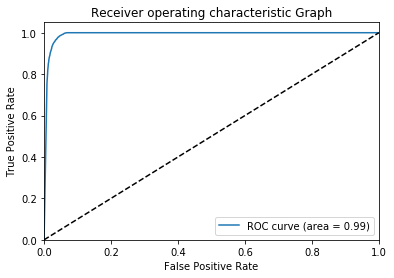

In [113]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()

***Exporting the fitted example pipeline model to a PMML file:***

In [114]:
from pyspark2pmml import PMMLBuilder

pmmlBuilder = PMMLBuilder(sc, df, pipelineModel) \.putOption(classifier, "compact", True)

pmmlBuilder.buildFile("StrokewithPysparkMLlib.pmml")

SyntaxError: unexpected character after line continuation character (<ipython-input-114-13625ee0f03c>, line 3)